#### 데이터 준비
```
$ mkdir -p ~/aiffel/stock_prediction/data
$ wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
$ wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
$ mv daily-min-temperatures.csv airline-passengers.csv ~/aiffel/stock_prediction/data
```

#### Time Series 생성

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [2]:
# 특정 열을 행으로 사용한다.
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

#### 시계열 안정성의 정성적 분석


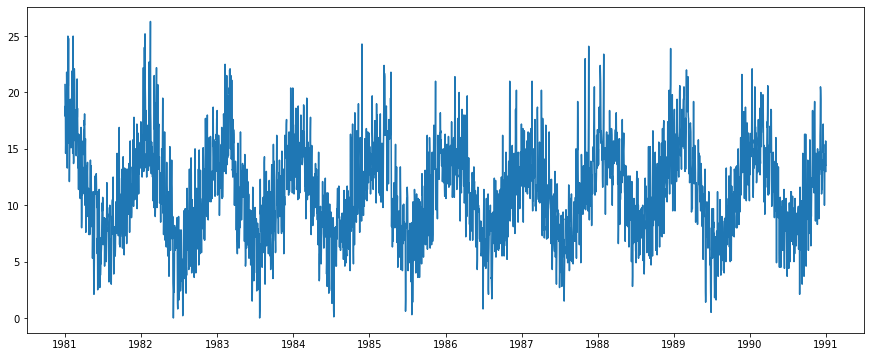

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 
plt.plot(ts1)

In [5]:
ts1[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')
ts1[ts1.isna()]    # 다시 NaN 확인

Series([], Name: Temp, dtype: float64)

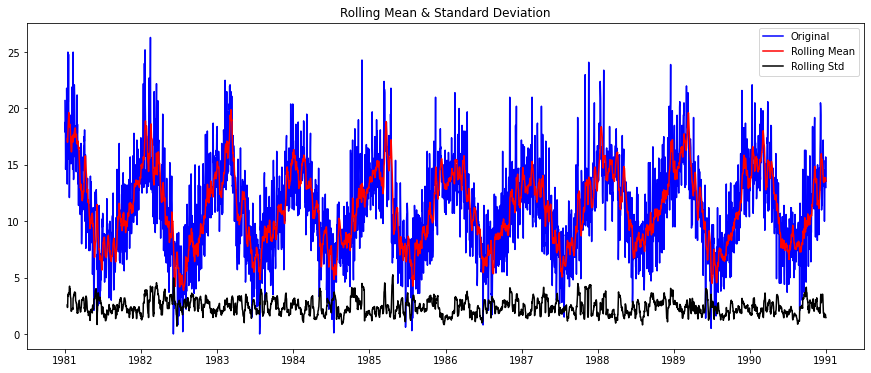

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts1, window=12)

#### 다른 데이터에 대해서도 비교해 보자.

In [8]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


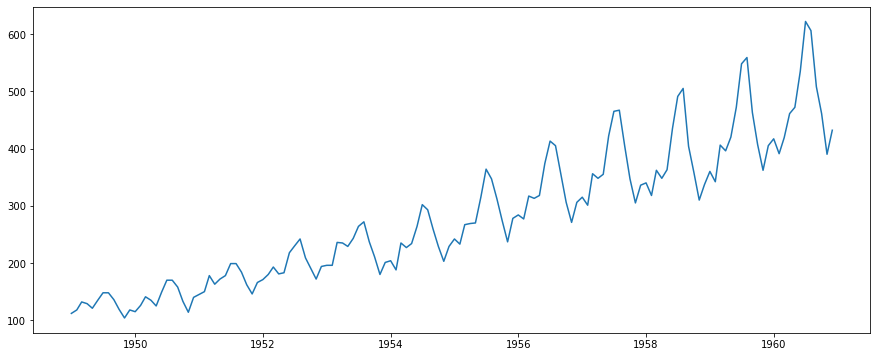

In [9]:
ts2 = df['Passengers']
plt.plot(ts2)

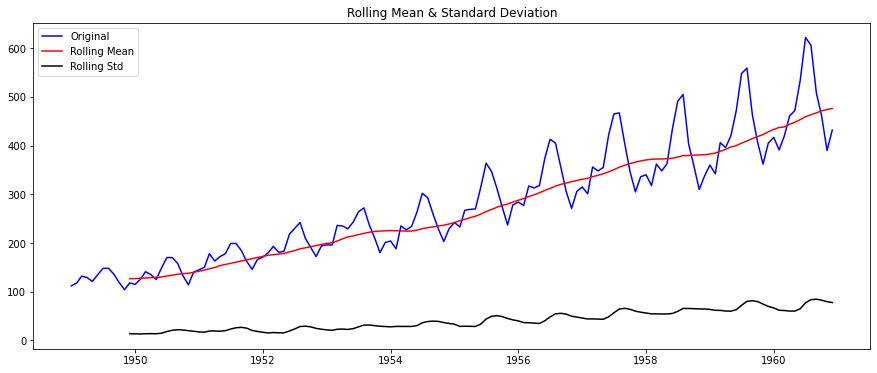

In [10]:
plot_rolling_statistics(ts2, window=12)

2번째 데이터는 첫 번째와 달리 시간에 대해 불안정하다는 것을 볼 수 있다.

In [11]:
!pip install statsmodels

#### Stationaty 시계열 여부 체크
사전지식
- 귀무가설 : 모집단의 특성에 대해 옳다고 제안하는 잠정적인 주장
- 대립가설 : 귀무가설이 거짓일때 대안적으로 참이 되는 가설
- 유의확률(p-value) : 귀무가설을 가정했을 때의 확률분포상에서 현재의 관측보다 더 극단적인 관측이 나올 확률. 이 값이 0.05 미만으로 매우 낮으면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택함.

Augmented Dickey-Fuller Test는 현재 데이터가 시계열이 아니라는 귀무가설하에 p-value를 측정하고 0.05 미만의 경우 대립가설로써 시계열이라 판단한다.

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [13]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [14]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### non stationary to startionary
##### 시도1. 로그함수 변환

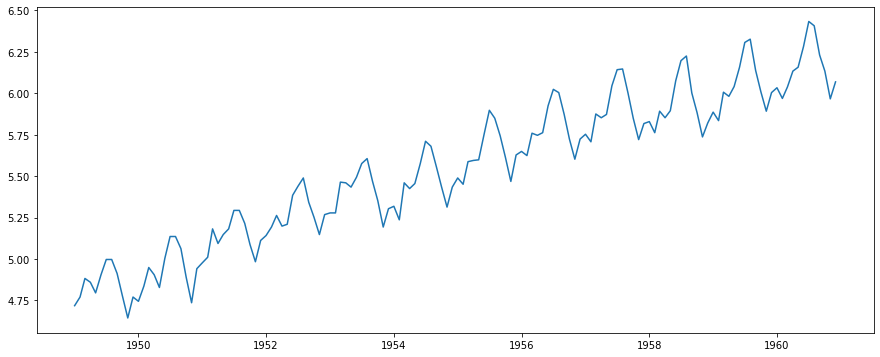

In [15]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [16]:
augmented_dickey_fuller_test(ts_log) # 로그변환에 대한 Test 확인

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


0.9에서 0.42로 대폭 줄은 것을 확인 할 수 있다.

##### 시도2. Moving average 제거 - Trend(시간 추이ㅔ 따라 나타나는 평균값 변화) 상쇄

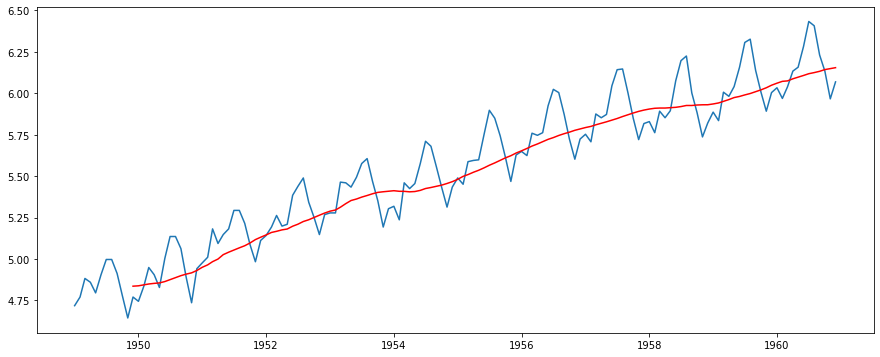

In [17]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average를 구해서 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [18]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [19]:
ts_log_moving_avg.dropna(inplace=True) # NaN 값들은 에러를 발생시키므로 drop한다.
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

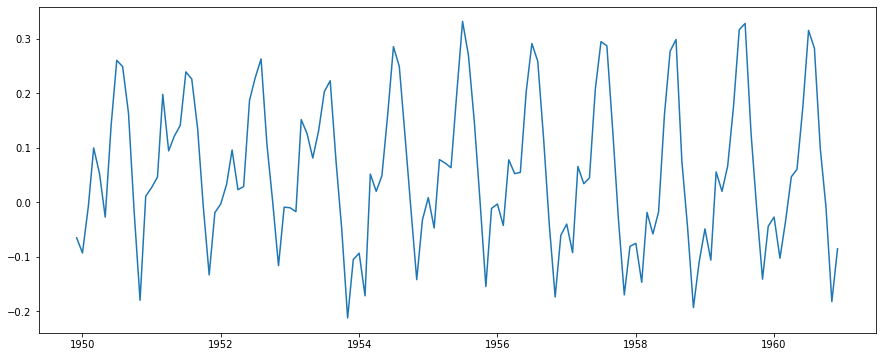

In [20]:
plt.plot(ts_log_moving_avg)

이전보다 안정된 것을 볼 수 있다.

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


##### 시도 2-2, 만약 window=6을 적용한다면?

In [22]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

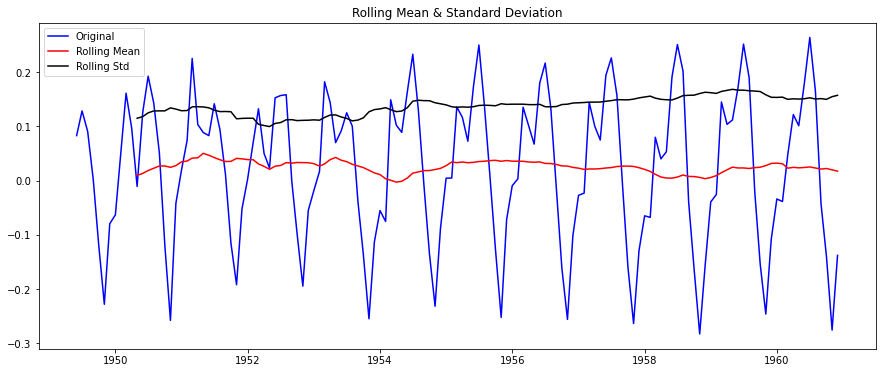

In [23]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [24]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


12개월 단위로 했을 때 보다 불안정적인 것을 확인할 수 있다.
이 해석으로 이 데이터셋은 12개월 단위로 주기성이 있다는 것을 추측할 수는 있지만 아직 안정적인 시계열이라고 하기에는 불확실하다

##### 시도3 - 차분(Differencing) - Seasonality 상쇄하기
Trend에서는 잡히지 않는 계절적, 주기적 패턴을 Seasonality라고 한다.
이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분이 있는데 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에서 빼 주는 방법이다(미분과 개념이 엇비슷하다).

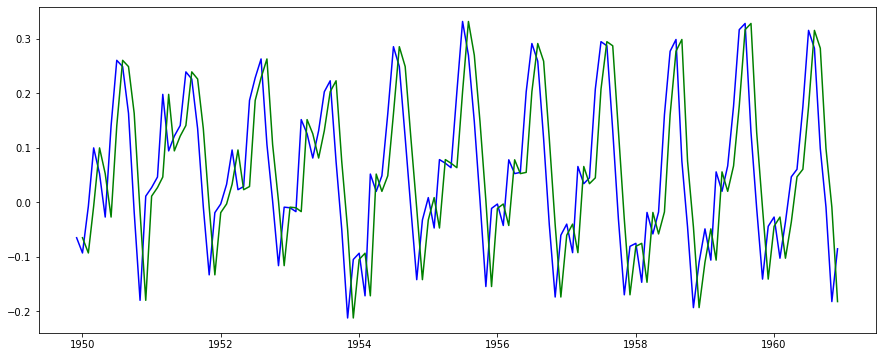

In [25]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

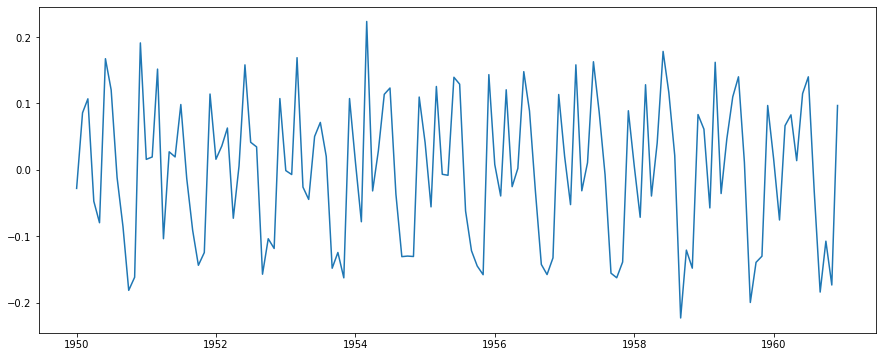

In [26]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

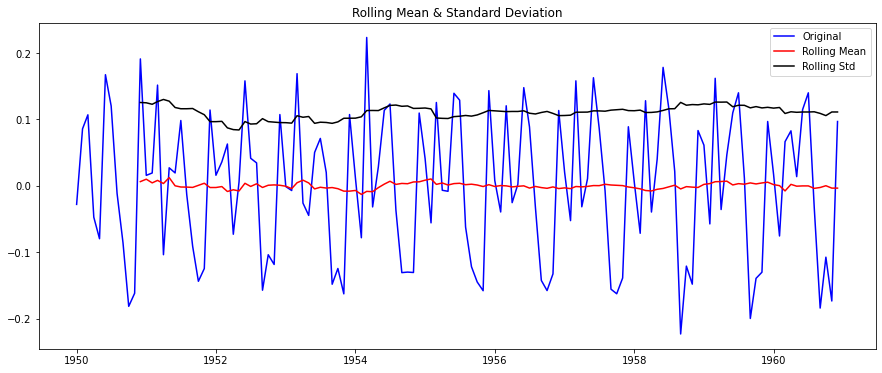

In [27]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [28]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


##### 시계열 분해
statsmodels 라이브러리 안에 seasonal_decompose 매소드를 이용하면 time series 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있다. 이 기능을 수행하면 위에서 직접 수행했던 과정들을 간편화 할 수있다.

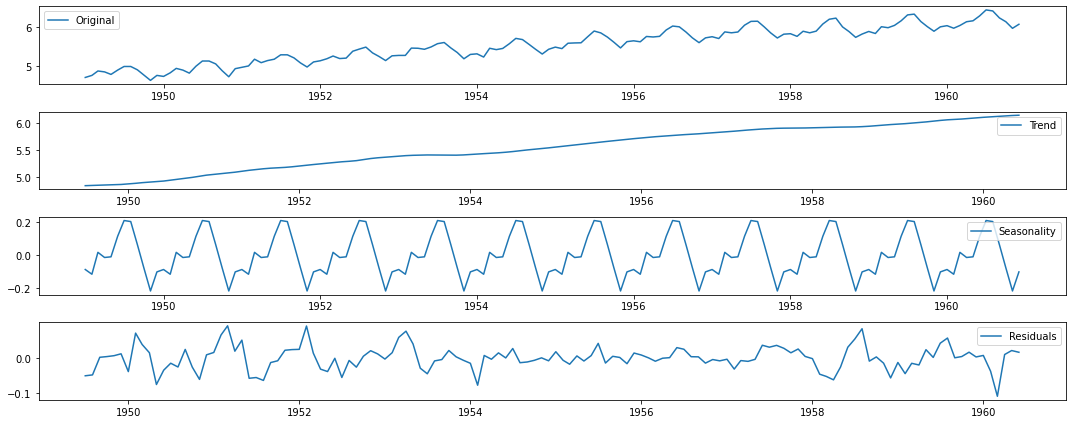

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals') # Origin-Trend-Sesonality =Residuals
plt.legend(loc='best')
plt.tight_layout()

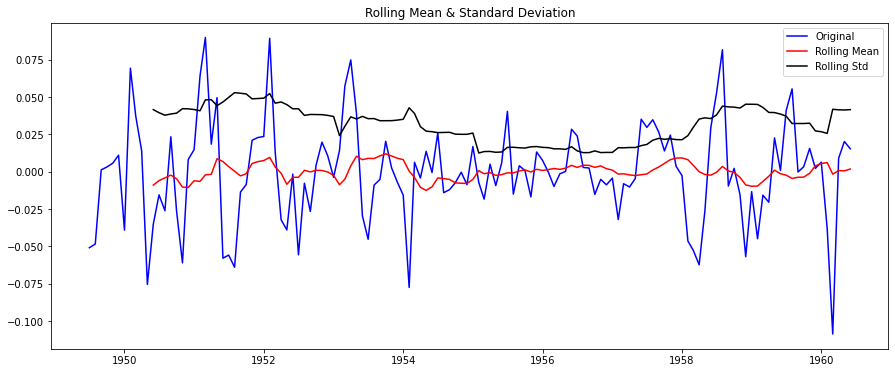

In [30]:
plot_rolling_statistics(residual)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


직접 계산하는 것 보다 더 정확한 과정을 거친다.

##### ARIMA 모델의 모수 p,q,d
p : 시차
q : 이동평균 모형(MA)의 시차
d : 차분 횟수

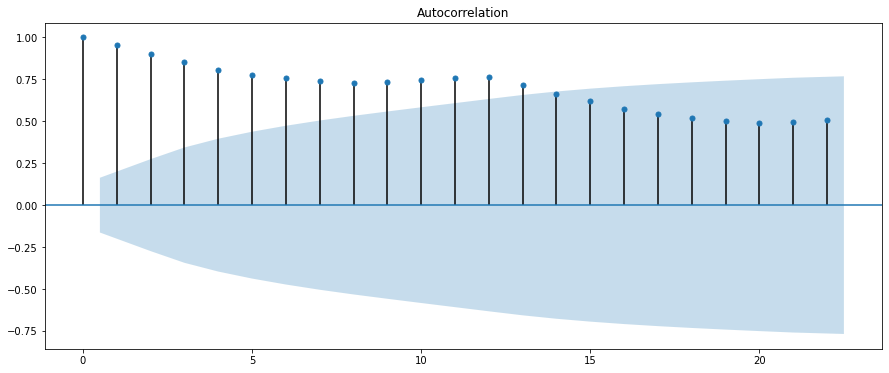

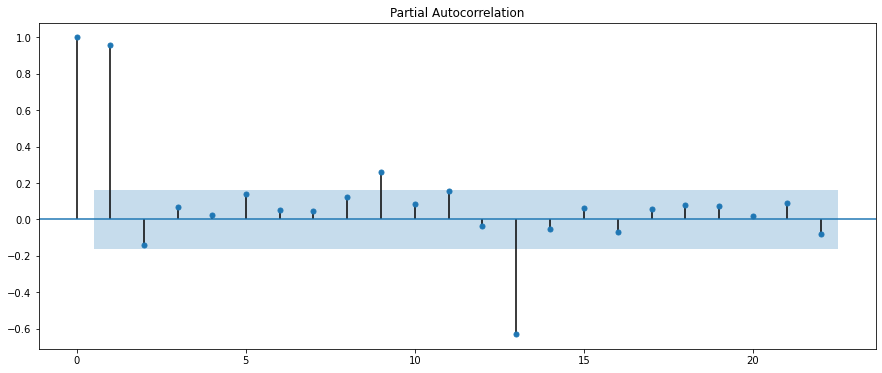

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기, 시차에 따른 관측치들 사이의 관련성 측정
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기, 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
plt.show()

 ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음

PACF 그래프에서 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에( 데이터 상관도가 0에 가깝기 때문에) 고려하지 않는다.
반면 ACF는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔가면서 확인해 보는 것도 좋다.

d를 구할 때는 d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해봐야한다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


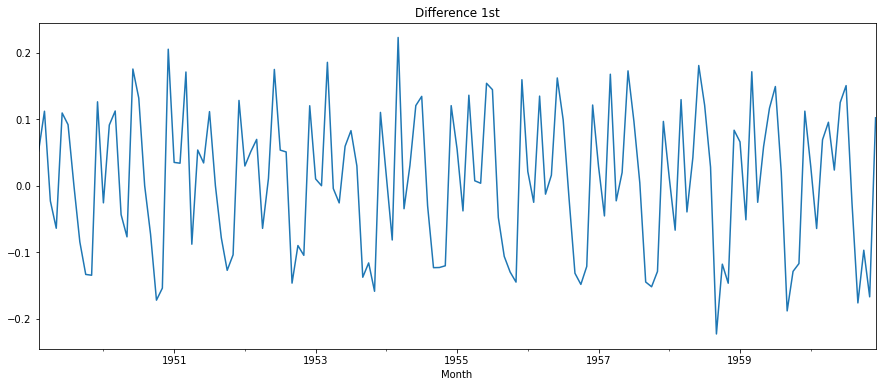

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


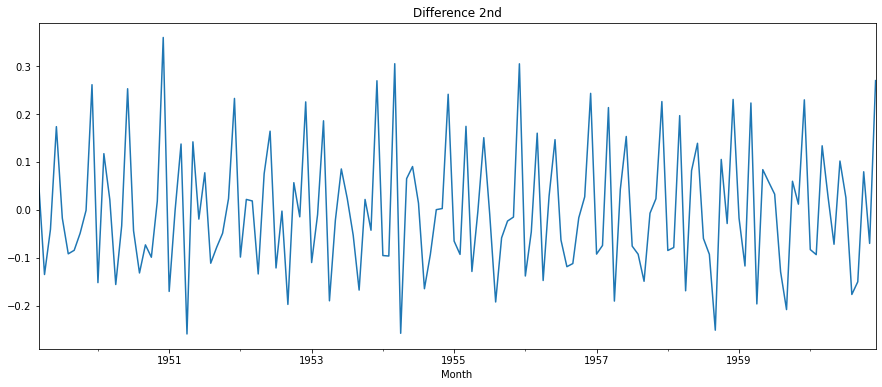

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 학습 데이터 분리

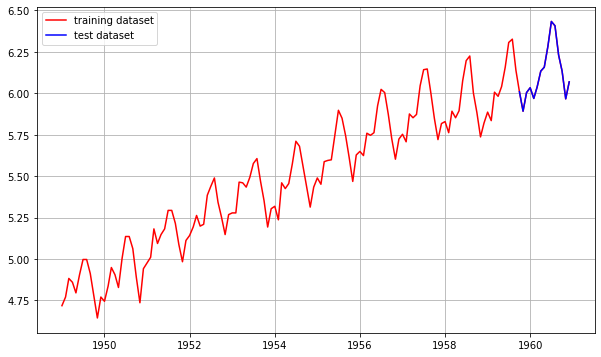

In [35]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [36]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Thu, 13 Aug 2020   AIC                           -210.046
Time:                        14:49:04   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


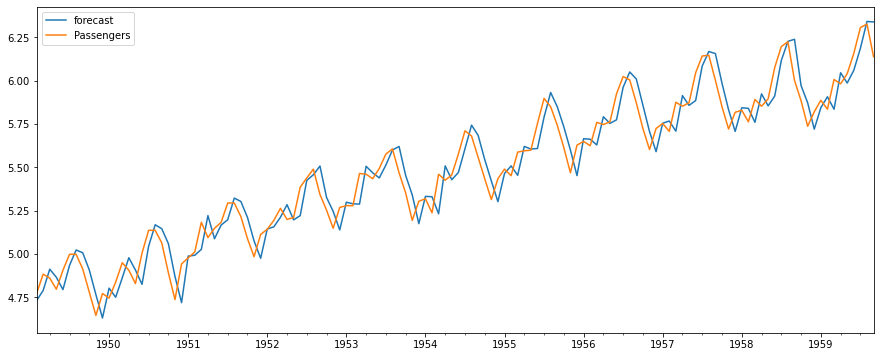

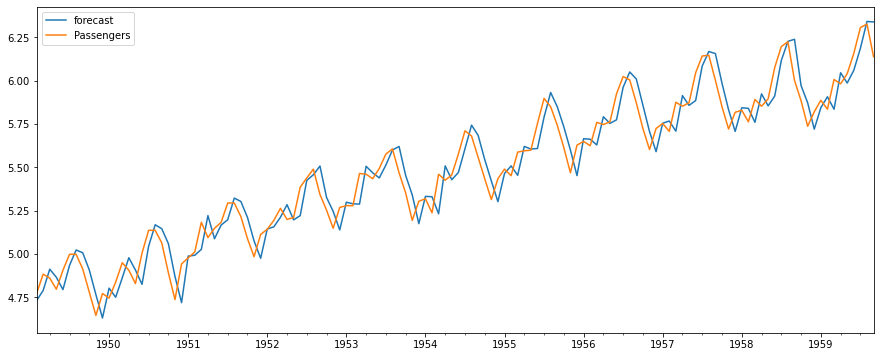

In [38]:
fitted_m.plot_predict()

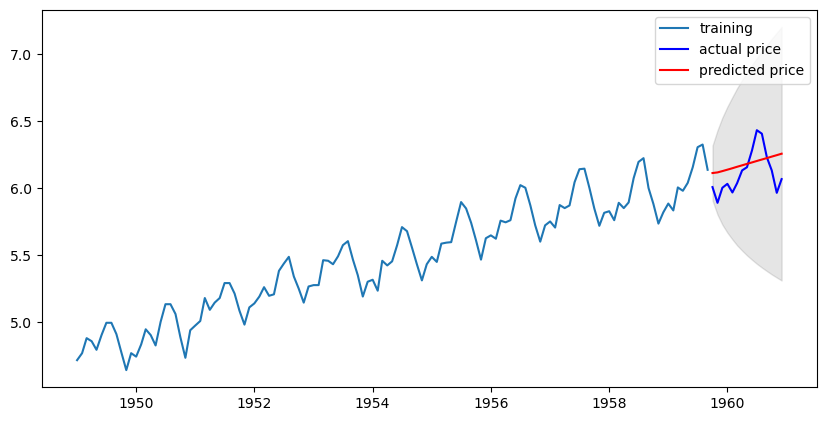

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.54942893038
MAE:  63.1369176973685
RMSE:  73.54963921686074
MAPE: 14.08%


# Samsung 주가 예측

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2019-08-13    43000.0
2019-08-14    43700.0
2019-08-16    43900.0
2019-08-19    43600.0
2019-08-20    44450.0
Name: Close, dtype: float64

#### 결측치 처리

In [42]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 로그변환

In [43]:
ts_log = np.log(ts)
print(min(ts_log))
print(max(ts_log))

10.657259354912508
11.041320554357519


#### 시계열 안정성 분석

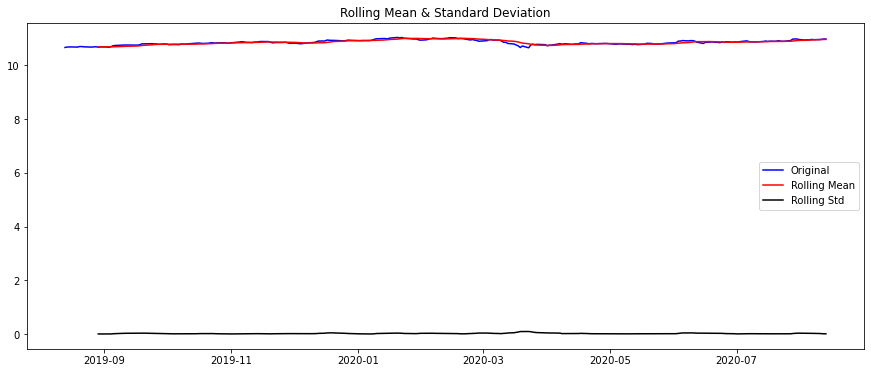

Results of Dickey-Fuller Test:
Test Statistic                  -2.241549
p-value                          0.191512
#Lags Used                       2.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


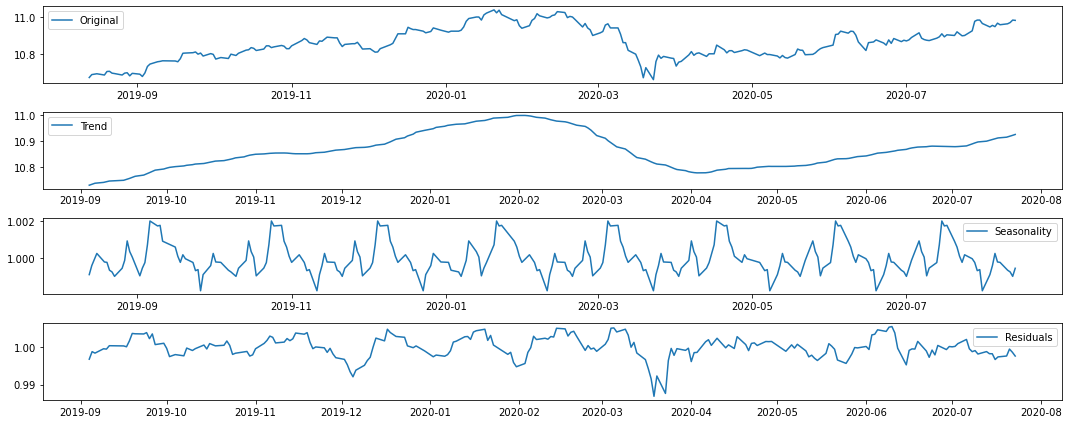

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.797974e+00
p-value                        4.703112e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


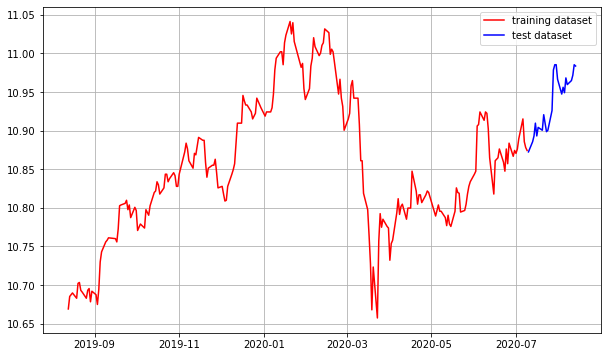

In [46]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

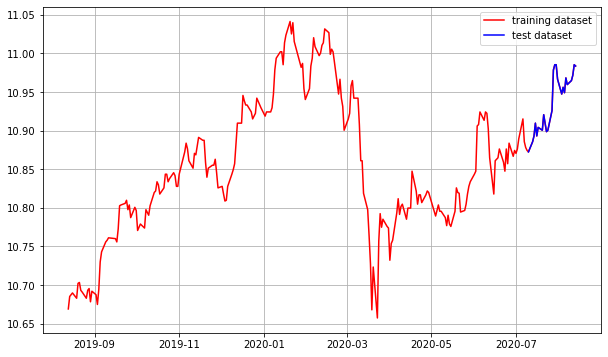

In [47]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

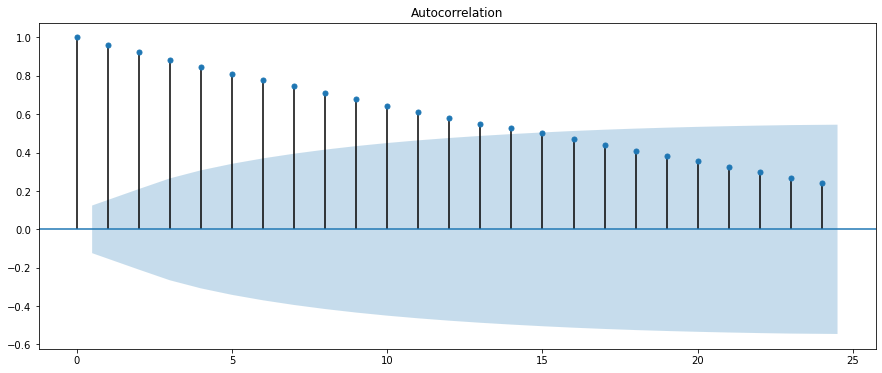

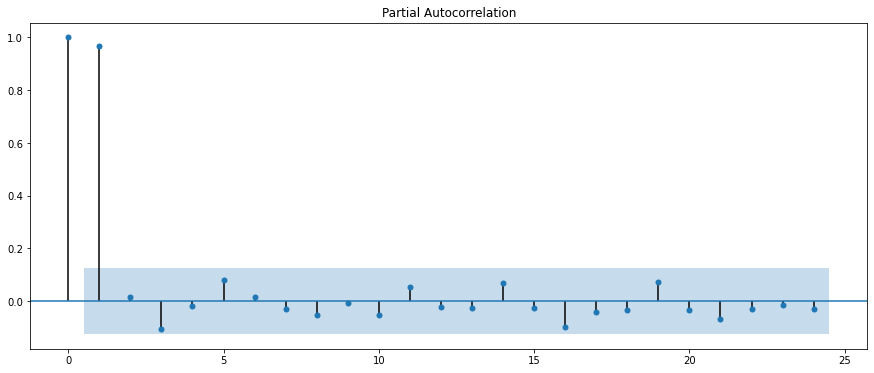

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.695793e+00
p-value                        1.105307e-16
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.961768e+00
p-value                        2.935651e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


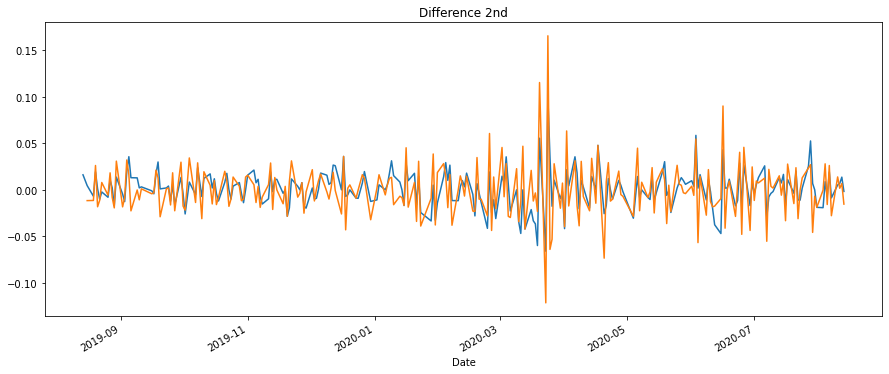

In [49]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [50]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 554.274
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 13 Aug 2020   AIC                          -1102.547
Time:                        14:49:06   BIC                          -1092.326
Sample:                             1   HQIC                         -1098.421
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.704      0.481      -0.002       0.003
ar.L1.D.Close    -0.0343      0.067     -0.513      0.608      -0.165       0.097
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


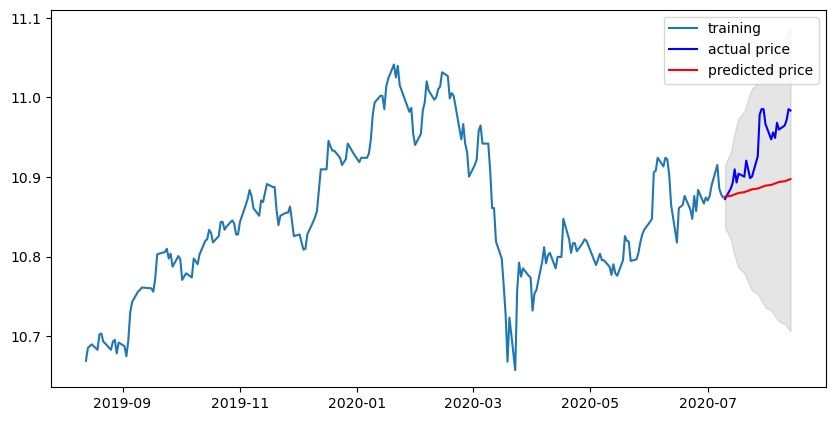

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs((np.exp(fc) - np.exp(test_data))/np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10870515.315688629
MAE:  2800.39716741594
RMSE:  3297.046453371355
MAPE: 4.87%


# APPLE 주가 예측

In [53]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AAPL.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts = df['Close']
print(type(ts))
ts

<class 'pandas.core.series.Series'>


Date
2019-08-13    208.970001
2019-08-14    202.750000
2019-08-15    201.740005
2019-08-16    206.500000
2019-08-19    210.350006
                 ...    
2020-08-06    455.609985
2020-08-07    444.450012
2020-08-10    450.910004
2020-08-11    437.500000
2020-08-12    452.040009
Name: Close, Length: 253, dtype: float64

In [54]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [55]:
ts_log = np.log(ts)
print(max(ts_log))
print(min(ts_log))

6.121637147487393
5.306979764411065


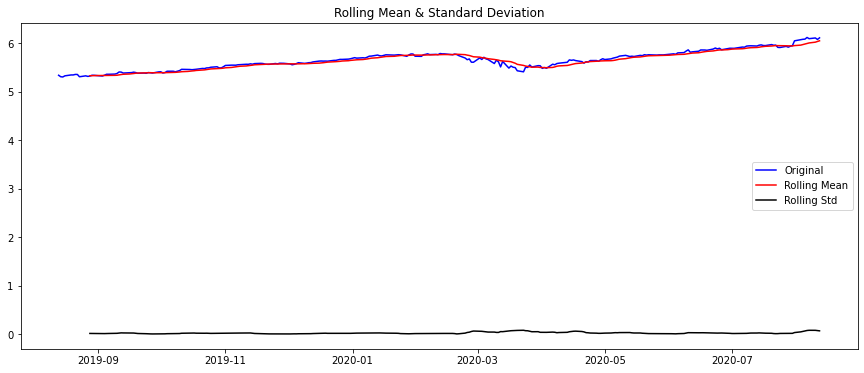

Results of Dickey-Fuller Test:
Test Statistic                  -0.149449
p-value                          0.944285
#Lags Used                       9.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


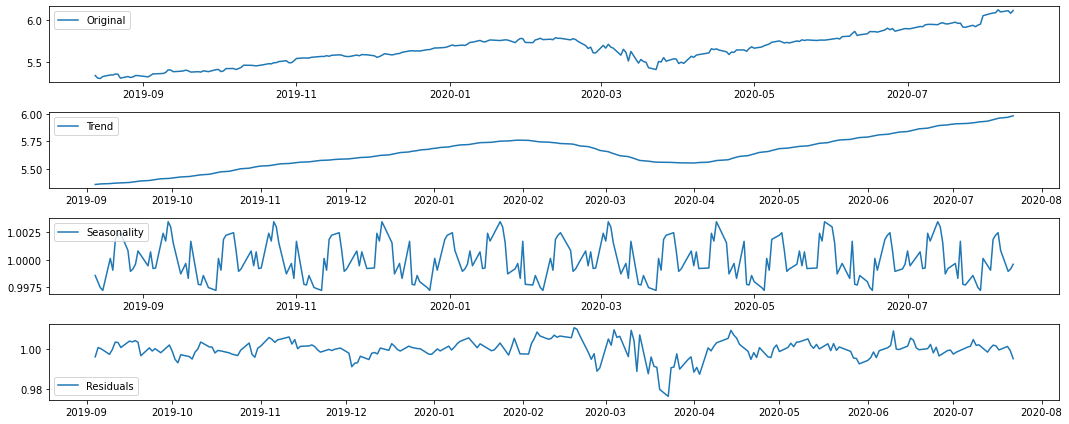

In [56]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.104582
p-value                          0.000952
#Lags Used                       9.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


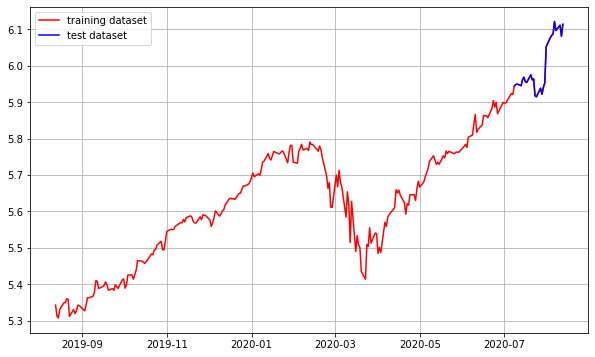

In [58]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

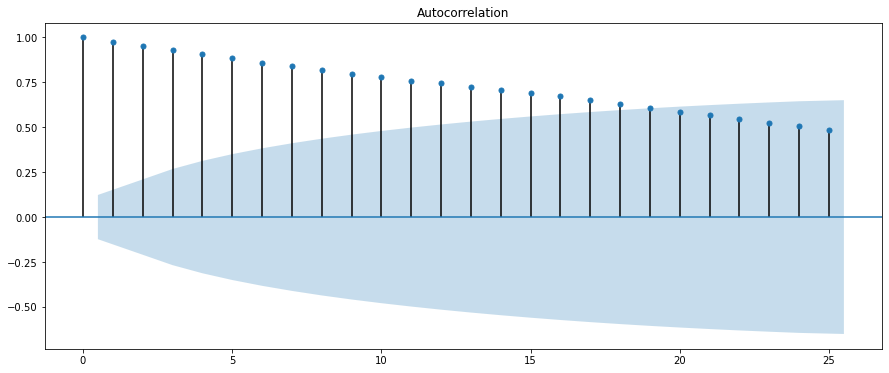

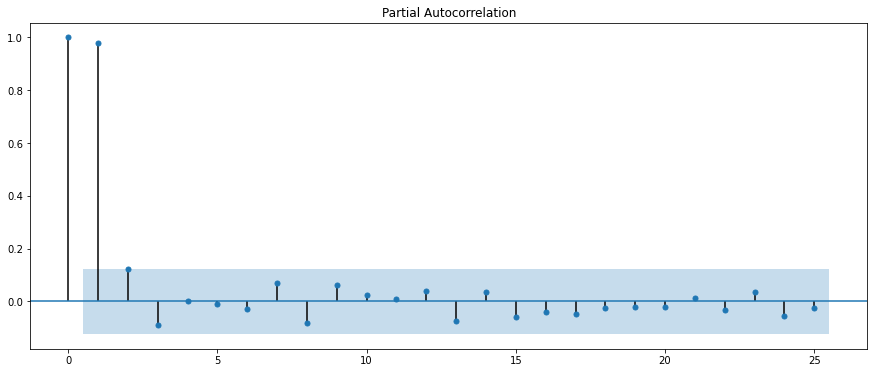

In [59]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.736616
p-value                          0.000072
#Lags Used                       8.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.695313e+00
p-value                        3.939523e-14
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.071005e+00
p-value                        1.549647e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Va

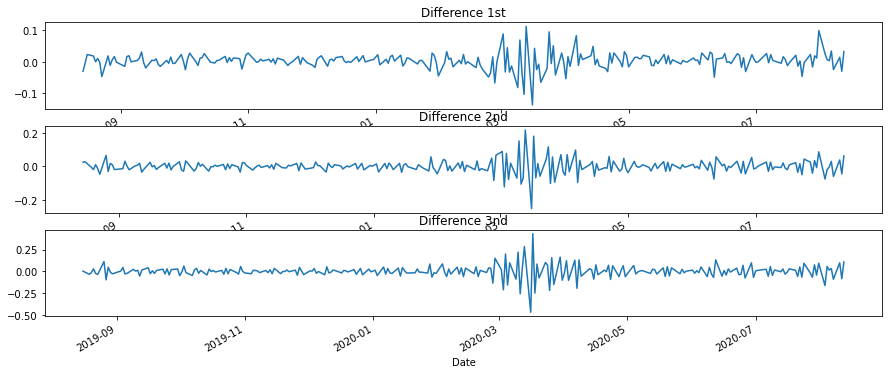

In [60]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
plt.subplot(311)
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
plt.subplot(312)
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

diff_3 = diff_2.diff(periods=1).iloc[1:]
plt.subplot(313)
diff_3.plot(title='Difference 3nd')

augmented_dickey_fuller_test(diff_3)

p=2,d=2,q=0

In [61]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model [2,2,0]= 6.83% [1,2,0] = 6.59% [1,1,0] = 5.15% [2,1,0] = 5.16%
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 515.098
Method:                       css-mle   S.D. of innovations              0.025
Date:                Thu, 13 Aug 2020   AIC                          -1024.196
Time:                        14:49:07   BIC                          -1013.935
Sample:                             1   HQIC                         -1020.055
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0026      0.001      2.107      0.035       0.000       0.005
ar.L1.D.Close    -0.3352      0.063     -5.346      0.000      -0.458      -0.212
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


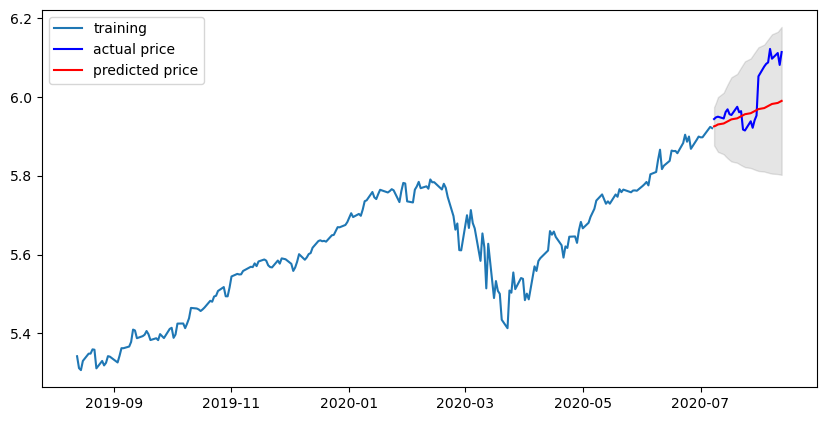

In [62]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  842.0021921077215
MAE:  21.934490586566923
RMSE:  29.017274029579717
MAPE: 5.15%


# Amazon 주가 예측

In [64]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
ts = df['Close']
print(type(ts))
ts

<class 'pandas.core.series.Series'>


Date
2019-08-13    1824.339966
2019-08-14    1762.959961
2019-08-15    1776.119995
2019-08-16    1792.569946
2019-08-19    1816.119995
                 ...     
2020-08-06    3225.000000
2020-08-07    3167.459961
2020-08-10    3148.159912
2020-08-11    3080.669922
2020-08-12    3162.239990
Name: Close, Length: 253, dtype: float64

In [65]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [66]:
ts_log = np.log(ts)
print(max(ts_log))
print(min(ts_log))

8.078688229229872
7.424529167691212


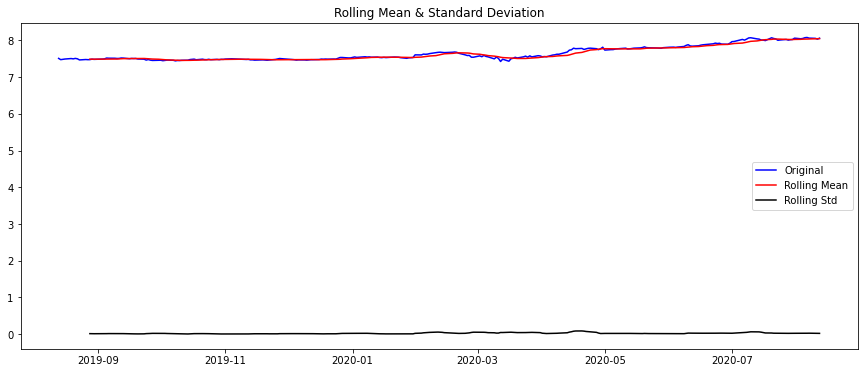

Results of Dickey-Fuller Test:
Test Statistic                   0.414381
p-value                          0.982025
#Lags Used                       2.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


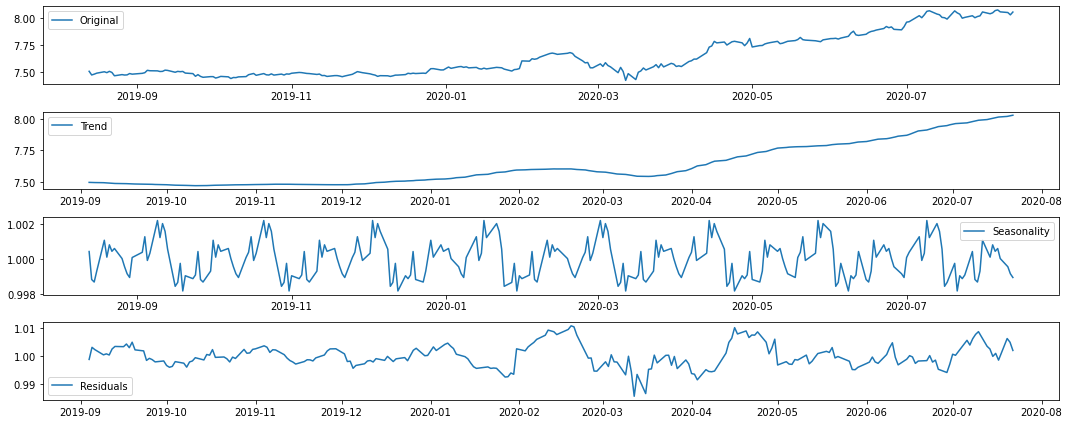

In [67]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

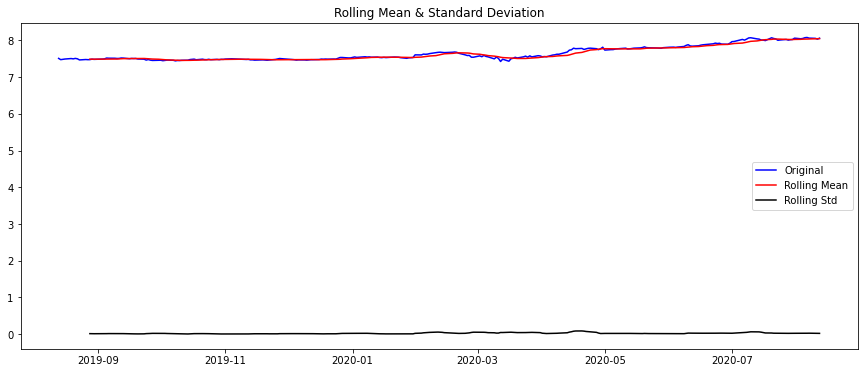

Results of Dickey-Fuller Test:
Test Statistic                   0.414381
p-value                          0.982025
#Lags Used                       2.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


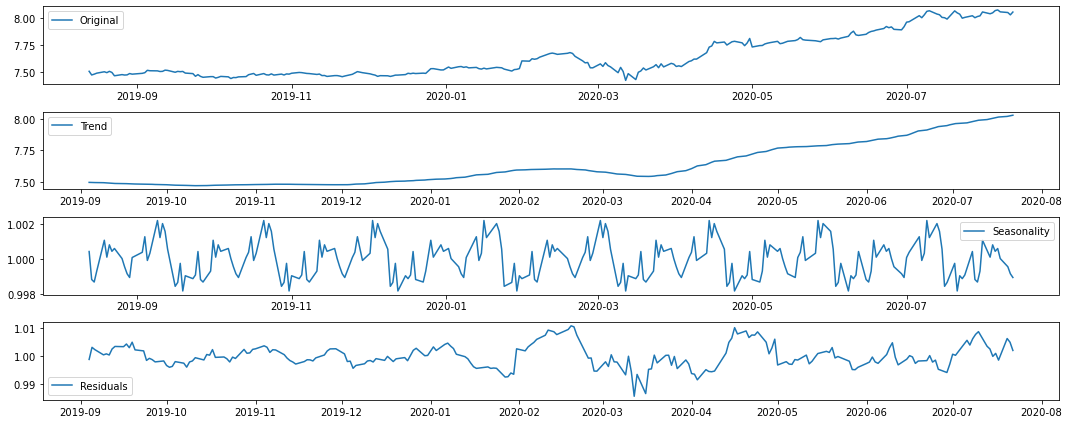

In [68]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [69]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.118990
p-value                          0.000901
#Lags Used                       8.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


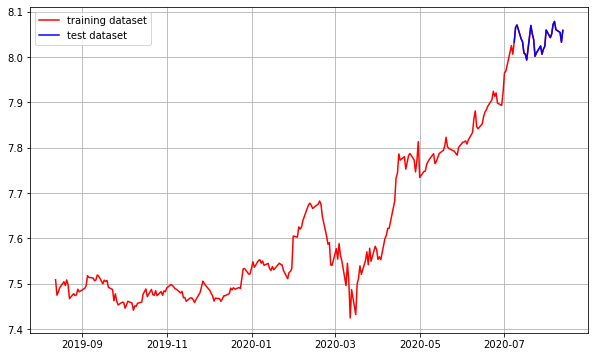

In [70]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

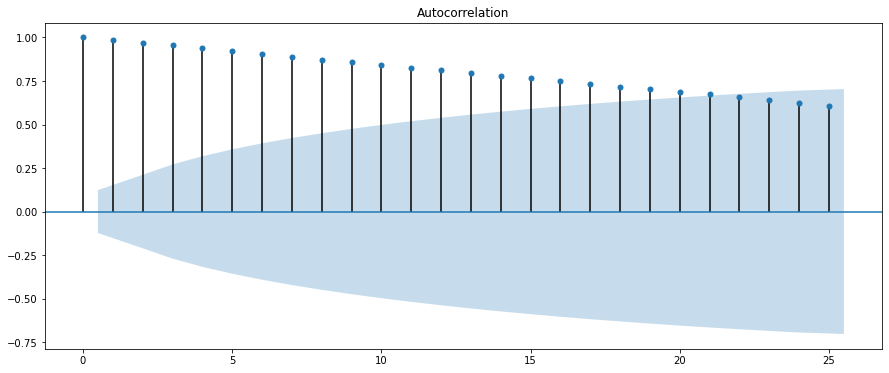

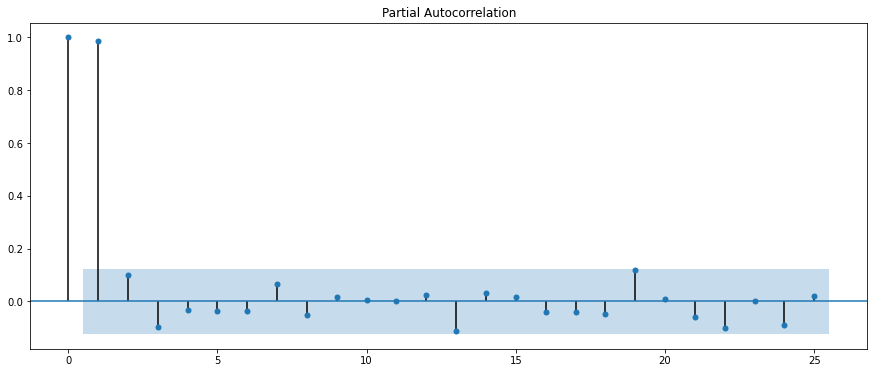

In [71]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.102860e+01
p-value                        5.743702e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.747230e+00
p-value                        2.900608e-14
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.822907e+00
p-value                        6.597106e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+

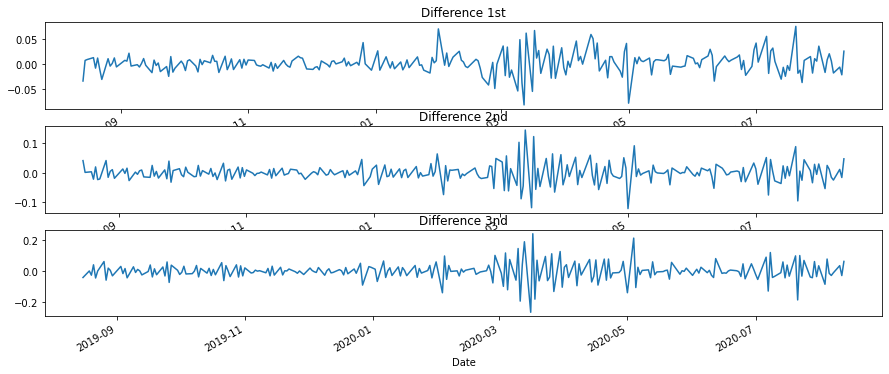

In [72]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
plt.subplot(311)
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
plt.subplot(312)
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

diff_3 = diff_2.diff(periods=1).iloc[1:]
plt.subplot(313)
diff_3.plot(title='Difference 3nd')

augmented_dickey_fuller_test(diff_3)

In [73]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 559.553
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 13 Aug 2020   AIC                          -1113.106
Time:                        14:49:09   BIC                          -1102.844
Sample:                             1   HQIC                         -1108.964
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.001      1.971      0.049    1.22e-05       0.004
ar.L1.D.Close    -0.1906      0.066     -2.898      0.004      -0.319      -0.062
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


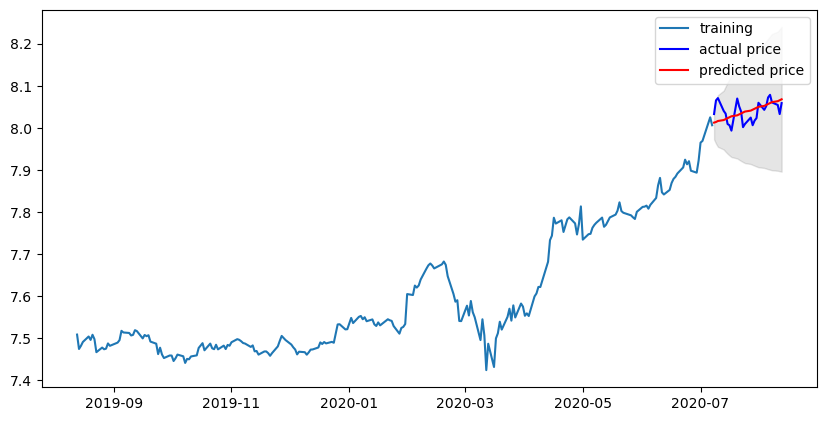

In [74]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6442.135350106537
MAE:  67.90030264260258
RMSE:  80.26291391487439
MAPE: 2.19%


#### Apple 예측할 때 p=2, d=2, q=0으로 예측을 했는데 실제 결과는 1,1,0이 왜 높은지 모르겠다.